## Setup

In [2]:
library(MCMCpack)
library(lattice)
obs.dat=dget("CompRank21.txt")

In [3]:
num.play = 24
concat_o = c()
concat_e = c()
concat_rank = c()
first = c()
final = c()
for (i in 1:length(obs.dat)){
  num.part = length(obs.dat[[i]]$o)
  concat_o = c(concat_o, obs.dat[[i]]$o)
  concat_e = c(concat_e, obs.dat[[i]]$e)
  concat_rank = c(concat_rank, c(1, rep(3, num.part-2), 2))
  first = c(first, obs.dat[[i]]$e[1])
  final = c(final, obs.dat[[i]]$e[num.part])
}

## 1. EDA

In [4]:
first_level = c()
final_level = c()
for (i in 1:length(first)){
  if (first[i]>=1 & first[i]<=5) {first_level = c(first_level, 1)}
  if (first[i]>=6 & first[i]<=10) {first_level = c(first_level, 2)}
  if (first[i]>=11) {first_level = c(first_level, 3)}
  if (final[i]>=1 & final[i]<=5) {final_level = c(final_level, 1)}
  if (final[i]>=6 & final[i]<=10) {final_level = c(final_level, 2)}
  if (final[i]>=11) {final_level = c(final_level, 3)}
}

In [5]:
library(ggplot2)
library(RColorBrewer)
t1=prop.table(table(c(first_level, final_level), c(rep(0, 134), rep(1, 134))), 2)
pdf("seniority.pdf", width=8, height=6)
bp1=barplot(t1, names=c("First player", "Last player"),
main="Distribution of seniority ranks among first-place and last-place players",
ylab="Distribution of seniority ranks", ylim=c(0, 1.2),
col=brewer.pal(5, "Set2"))
legend(x=1.7, y=1.22, legend=c("Seniority 1-5", "Seniority 6-10", "Seniority 11-16"), bty="n",
fill=brewer.pal(5, "Set2"))
text(bp1, 0, round(t1[1,], 2), cex=1, pos=3)
text(bp1, 0.56, round(t1[2,], 2), cex=1, pos=3)
text(bp1, 0.91, round(t1[3,], 2), cex=1, pos=3)
dev.off()

pdf 
  2

In [6]:
pdf("player.pdf", width=12, height=6)
counts = table(concat_rank, concat_o)
barplot(counts, main="Distribution of rank among players",
        xlab="Player label", ylab="Count", 
        col=c("darkblue","red", "white"),
        legend=c("first place", "last place", "otherwise"))
dev.off()

pdf 
  2

In [7]:
prop.table(counts[, counts[1, ] + counts[2, ] + counts[3, ] > 10], 2)

           concat_o
concat_rank          5          7          8          9         10         11
          1 0.10000000 0.55319149 0.44444444 0.00000000 0.37662338 0.32258065
          2 0.55000000 0.21276596 0.29629630 0.87500000 0.40259740 0.29032258
          3 0.35000000 0.23404255 0.25925926 0.12500000 0.22077922 0.38709677
           concat_o
concat_rank         12         15         19
          1 0.66666667 0.25000000 0.77777778
          2 0.16666667 0.44444444 0.05555556
          3 0.16666667 0.30555556 0.16666667

## 2. Observation Model

### Prior Function

In [8]:
lpr_l<-function(lambda_dim, beta){
  log.prior <- sum(dt(lambda,df=5,log=TRUE)) 
  return(log.prior)
}

lpr<-function(lambda, beta){
  log.prior <- sum(dt(lambda,df=5,log=TRUE)) + sum(dt(beta,df=5,log=TRUE))
  return(log.prior)
}

### First Model

In [13]:
model_one<-function(lambda, oli){
  # oli: list of player labels
  prob <- 1
  for (i in 1:length(oli)) {
    density <- 0
    for (j in i:length(oli)) {density <- density + exp(lambda[oli[j]])}
    prob <- prob * (exp(lambda[oli[i]]) / density)
  }
  return(prob)
}

llk_one<-function(lambda){ 
  log.likelihood <- 0
  for (k in 1:length(obs.dat)){
    oli <- obs.dat[[k]]$o
    log.likelihood <- log.likelihood + log(model_one(lambda, oli))
  }
  return(log.likelihood)
}
# llk_one(rt(num.play, 5))

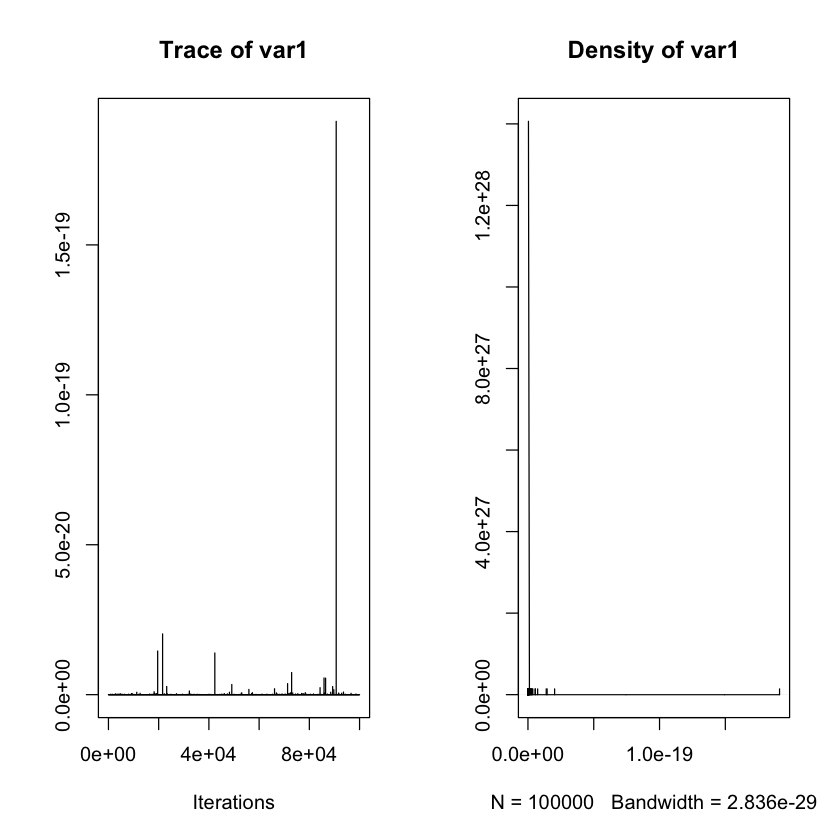

In [14]:
K <- 100000
out <- matrix(NA, K, 1)
for (k in 1:K) {
  lambda <- rt(num.play, df=5)
  out[k,] <- model_one(lambda, c(1:24))
}
plot(as.mcmc(out)) 

### Second Model

In [21]:
model_two<-function(lambda, beta, oli, eli){
  # oli: list of player labels
  # eli: list of seniority ranks 
  prob <- 1
  for (i in 1:length(oli)) {
    density <- 0
    for (j in i:length(oli)) {density <- density + exp(lambda[oli[j]] + beta[eli[j]])}
    prob <- prob * exp(lambda[oli[i]] + beta[eli[i]]) / density
  }
  return(prob)
}

llk_two<-function(lambda, beta){ 
  log.likelihood <- 0
  for (k in 1:length(obs.dat)){
    oli <- obs.dat[[k]]$o
    eli <- obs.dat[[k]]$e
    log.likelihood <- log.likelihood + log(model_two(lambda, beta, oli, eli))
  }
  return(log.likelihood)
}
# llk_one(rt(num.play, 5), rt(num.play, 5))

### Validation -- Model 1

In [84]:
require(gtools)

In [85]:
K <- 10000
out_one <- matrix(NA, K, 6)
for (k in 1:K) {
  lambda=rt(24, df=1)
  perm_o=permutations(3, 3, v=c(1, 2, 3))
  for (i in c(1:6)) {out_one[k, i]=model_one(lambda, perm_o[i, ])}
}

In [86]:
pdf("one_t1.pdf", width=6, height=6)
plot(density(na.omit(out_one)[,1]), xlab=expression("Likelihood p(O=o | lambda)"), ylab="Density", main=c('Likelihood with t(1) prior'))
for (i in c(2:6)) {lines(density(na.omit(out_one)[,i]), col=i)}
legend("topright", legend=c("c(1, 2, 3)", "c(1, 3, 2)", "c(2, 1, 3)", "c(2, 3, 1)", "c(3, 1, 2)", "c(3, 2, 1)"), 
       col=c(1, 2, 3, 4, 5, 6), lty=1, cex=0.8)
dev.off()

pdf 
  2

### Validation -- Model 2

In [68]:
K <- 10000
out_two <- matrix(NA, K, 36)
for (k in 1:K) {
  lambda=rt(24, df=5)
  beta=rt(24, df=5)
  perm_o=permutations(3, 3, v=c(1, 2, 3))
  perm_b=permutations(3, 3, v=c(1, 2, 3))
  for (i in c(1:6)) {for (j in c(1:6)) {out_two[k, 6*(i-1) + j]=model_two(lambda, beta, perm_o[i, ], perm_b[j, ])}}
}

In [69]:
pdf("two_t5.pdf", width=8, height=7)
plot(density(na.omit(out_two)[,1]), xlab=expression("Likelihood p(O=o | lambda, beta)"), ylab="Density", main=c('Likelihood with t(5) prior'))
for (i in c(2:36)) {lines(density(na.omit(out_two)[,i]), col=i)}
legend("topright", legend=c("perm(o1, o2, o3), perm(e1, e2, e3)"), 
       col=c(1), lty=1, cex=0.8)
# legend(0.8, 4.7, lty=1, cex=0.8)
dev.off()

pdf 
  2

## 3. MCMC

### First MCMC

In [11]:
### Sampling from the first model ###
#initialise state for MCMC
K=100000; SS=100; 
# mcmc_1st: lambda=rep(0, num.play) 
# mcmc_2nd: lambda=rnorm(num.play)
# mcmc_3rd: lambda=rt(num.play, 5)
lambda=rep(0, num.play)

olpr_l=lpr_l(lambda)
ollk=llk_one(lambda)

out.mcmc=matrix(NA, K/SS, num.play+2)
colnames(out.mcmc)=c(c(1:24), 'olpr', 'ollk')
for (k in 1:K) {
  #proposal distribution is the prior so the MHR is L(theta';y)/L(theta;y)
  for (i in 1:num.play) {
    lambdap=lambda
    lambdap[i]=rt(1, df=5)
    nllk=llk_one(lambdap)
    logMHR=nllk-ollk
    if (log(runif(1))<logMHR) {
      lambda=lambdap
      olpr_l=lpr_l(lambda)
      ollk=nllk
    }
  }
  if (k%%SS==0) {
    out.mcmc[k/SS,]=c(lambda, olpr_l, ollk)
  }
}

### Second MCMC

In [31]:
### Sampling from the second model ###
K=100000; SS=100; 
# mcmc_1st
# lambda=rep(0, num.play)
# beta=rep(0, num.play) 

# mcmc_2nd
lambda=rt(num.play, 5) 
beta=rt(num.play, 5) 

# mcmc_3rd
# lambda=rnorm(num.play)
# beta=rnorm(num.play)

olpr=lpr(lambda, beta)
ollk=llk_two(lambda, beta)

out.mcmc=matrix(NA, K/SS, num.play+num.play+2)
colnames(out.mcmc)=c(sprintf("lambda_%d", 1:24), sprintf("beta_%d", 1:24), 'olpr', 'ollk')

for (k in 1:K) {
  #proposal distribution is the prior so the MHR is L(theta';y)/L(theta;y)
  for (i in 1:num.play) {
    lambdap=lambda
    lambdap[i]=rt(1, df=5)
    nllk=llk_two(lambdap, beta)
    logMHR=nllk-ollk
    if (log(runif(1))<logMHR) {
      lambda=lambdap
      olpr=lpr(lambda, beta)
      ollk=nllk
    }
  }

  for (i in 1:num.play) {
    betap=beta
    betap[i]=rt(1, df=5)
    nllk=llk_two(lambda, betap)
    logMHR=nllk-ollk
    if (log(runif(1))<logMHR) {
      beta=betap
      olpr=lpr(lambda, beta)
      ollk=nllk
    }
  }
  if (k%%SS==0) {
    out.mcmc[k/SS,]=c(lambda, beta, olpr, ollk)
  }
}

### Output Analysis

In [109]:
model_two_mcmc_1st = readRDS("model_two_mcmc_1st.Rda")
model_two_mcmc_2nd = readRDS("model_two_mcmc_2nd.Rda")
model_two_mcmc_3rd = readRDS("model_two_mcmc_3rd.Rda")

In [128]:
pdf("xyplot.pdf", width=7, height=7)
xyplot(out.mcmc<-as.mcmc(model_two_mcmc_1st[, c(49, 50, 1, 13, 25, 37)]))
dev.off()

pdf 
  2

In [163]:
pdf("overlay.pdf", width=12, height=3)
par(mfrow=c(1,4))
comps=c(1, 25, 49, 50)
mains=c("lambda_1", "beta_1", "log-prior", "log-likelihood")
for (i in 1:4) {
  plot(density(model_two_mcmc_1st[, comps[i]]), main=mains[i], xlab=mains[i], ylab="density")
  lines(density(model_two_mcmc_2nd[, comps[i]]), col=2)
  lines(density(model_two_mcmc_3rd[, comps[i]]), col=3)
  legend("topright", legend=c("run_1", "run_2", "run_3"), 
         col=c(1, 2, 3), lty=1, cex=0.8)
}
dev.off()

pdf 
  2

In [370]:
model_one_mcmc_1st = readRDS("model_one_mcmc_1st.Rda")

In [371]:
effectiveSize(as.mcmc(model_one_mcmc_1st))

1         2         3         4         5         6         7         8 
1132.1440  884.0323 1000.0000 1000.0000 1000.0000 1000.0000 1000.0000 1230.7271 
        9        10        11        12        13        14        15        16 
1000.0000 1000.0000 1000.0000 1000.0000  960.4776 1000.0000 1000.0000 1000.0000 
       17        18        19        20        21        22        23        24 
1077.1409  798.3141 1000.0000  824.7120  879.4881 1000.0000 1000.0000 1000.0000 
     olpr      ollk 
1000.0000 1000.0000

In [189]:
pdf("acf.pdf", width=8, height=8)
par(mfrow = c(2,2))
for (i in 1:4) {
  plot(acf(model_two_mcmc_1st[, comps[i]], lag.max=200, plot=F),main=mains[i],xlab="LAG",ylab="ACF",
       type='l',ann=F,xaxp=c(0,200,2),yaxp=c(0,1,1))
  text(50, 0.8, colnames(model_two_mcmc_1st)[comps[i]])
}
dev.off()

pdf 
  2

## 4. Model Validation

### Bayes Factor

In [122]:
### posterior mean verify -- refer to question 1

In [354]:
OP.one = readRDS("model_one_mcmc_1st.Rda")
OP.two = readRDS("model_two_mcmc_1st.Rda")

In [182]:
# Bridge estimate marginal lkd of model one
n.samp=dim(OP.one)[1]; n.samp.p=100*n.samp
lambda.pri=matrix(NA, n.samp.p, num.play)
for (k in 1:n.samp.p) {lambda.pri[k,]=rt(num.play, 5)}
lambda.pos=OP.one[,1:num.play]
L.pri=rep(NA,n.samp.p); L.pos=rep(NA,n.samp)
for (k in 1:n.samp) {L.pos[k]=llk_one(lambda.pos[k,])}
for (k in 1:n.samp.p) {L.pri[k]=llk_one(lambda.pri[k,])}
ml.one=mean(exp(L.pri/2))/mean(exp(-L.pos/2))

In [183]:
# Bridge estimate marginal lkd of model two
n.samp=dim(OP.two)[1]; n.samp.p=100*n.samp
lambda.pri=matrix(NA, n.samp.p, num.play)
beta.pri=matrix(NA, n.samp.p, num.play)
for (k in 1:n.samp.p) {lambda.pri[k,]=rt(num.play, 5)}
for (k in 1:n.samp.p) {beta.pri[k,]=rt(num.play, 5)}
lambda.pos=OP.two[,1:num.play]
beta.pos=OP.two[,(num.play+1):(2*num.play)]
L.pri=rep(NA,n.samp.p); L.pos=rep(NA,n.samp)
for (k in 1:n.samp) {L.pos[k]=llk_two(lambda.pos[k,], beta.pos[k,])}
for (k in 1:n.samp.p) {L.pri[k]=llk_two(lambda.pri[k,], beta.pri[k,])}
ml.two=mean(exp(L.pri/2))/mean(exp(-L.pos/2))

In [184]:
Bayes.Factor=ml.two/ml.one
Bayes.Factor

[1] 4.986494e-06

### Posterior Mean

In [368]:
summary(OP.one)

       1                 2                  3                 4          
 Min.   :-5.3373   Min.   :-6.01775   Min.   :-9.7450   Min.   :-1.1260  
 1st Qu.:-1.1873   1st Qu.:-2.87135   1st Qu.:-1.9499   1st Qu.: 0.8332  
 Median :-0.6512   Median :-2.23108   Median :-1.1722   Median : 1.3287  
 Mean   :-0.6697   Mean   :-2.30680   Mean   :-1.3543   Mean   : 1.3536  
 3rd Qu.:-0.1254   3rd Qu.:-1.63448   3rd Qu.:-0.5575   3rd Qu.: 1.8430  
 Max.   : 1.5664   Max.   :-0.07622   Max.   : 1.0336   Max.   : 4.1655  
       5                  6                 7                 8           
 Min.   :-2.27558   Min.   :-4.3964   Min.   :-0.2623   Min.   :-1.26643  
 1st Qu.:-0.74784   1st Qu.:-0.6217   1st Qu.: 0.5232   1st Qu.: 0.01206  
 Median :-0.44275   Median :-0.1002   Median : 0.7654   Median : 0.30246  
 Mean   :-0.44513   Mean   :-0.1069   Mean   : 0.7632   Mean   : 0.29515  
 3rd Qu.:-0.09716   3rd Qu.: 0.4222   3rd Qu.: 0.9828   3rd Qu.: 0.58154  
 Max.   : 0.82418   Max.   : 2.4

In [369]:
round(HPDinterval(as.mcmc(OP.one)), 2)

,lower,upper
1,-2.18,0.85
2,-4.09,-0.44
3,-3.68,0.52
4,-0.11,2.97
5,-1.41,0.42
6,-1.75,1.50
7,0.07,1.51
8,-0.54,1.13
9,-3.58,-1.01
10,-0.19,1.05


## 5. Relative Skills

### Model 1

In [361]:
odds_matrix_one = matrix(NA, num.play, num.play)
for (i in 1:num.play){
  for (j in 1:num.play){
    skill_i = exp(mean(OP.two[,i]))
    skill_j = exp(mean(OP.two[,j]))
    odds_matrix_one[i, j] = skill_i / (skill_i + skill_j)
  }
}

### Model 2

In [362]:
odds_matrix_two = matrix(NA, num.play, num.play)
for (i in 1:num.play){
  for (j in 1:num.play){
    skill_i = exp(mean(OP.two[,i]) + mean(OP.two[,num.play+i]))
    skill_j = exp(mean(OP.two[,j]) + mean(OP.two[,num.play+j]))
    odds_matrix_two[i, j] = skill_i / (skill_i + skill_j)
  }
}

### Model Difference

In [339]:
odds_matrix = odds_matrix_one - odds_matrix_two

In [364]:
library(ggplot2)
library(viridis)
x=c(1:24); y=c(1:24)
data=expand.grid(X=x, Y=y)
# data$Z=as.vector(odds_matrix_one) 
data$Z=as.vector(odds_matrix_one) 

pdf("heat_one.pdf", width=5.3, height=5)
ggplot(data, aes(X, Y, fill= Z))+ 
labs(x="Player label", y="Player label")+
geom_tile()+
scale_fill_viridis(discrete=FALSE)
dev.off()

pdf 
  2

## 6. Answer Questions

In [256]:
require(gtools)
perm = permutations(8, 8, v=obs.dat[[68]]$o[-2])

### Model 1

In [257]:
model_one_mcmc = readRDS("model_one_mcmc_1st.Rda")

In [258]:
K = 1000
perm = permutations(8, 8, v=obs.dat[[68]]$o[-2])
result_one = matrix(NA, K, dim(perm)[1])
for (k in 1:K) {
  lambda = rep(NA, num.play)
  for (i in c(1:num.play)){
    dens = density(model_one_mcmc[, i])
    lambda[i] = sample(dens$x, 1, replace=TRUE, prob=dens$y)
  }
  for (j in c(1:dim(perm)[1])){
    po = c(7, perm[j, ])
    result_one[k, j]=model_one(lambda, po)
  }
}

In [167]:
saveRDS(result_one, "result_one.Rda")

In [168]:
sum(colMeans(result_one))

[1] 0.1740131

### Model 2

In [304]:
model_two_mcmc = readRDS("model_two_mcmc_1st.Rda")

In [305]:
K = 1000
perm = permutations(8, 8, v=obs.dat[[68]]$o[-2])
result_two = matrix(NA, K, dim(perm)[1])
for (k in 1:K) {
  lambda = rep(NA, num.play)
  beta = rep(NA, num.play)
  for (i in c(1:num.play)){
    dens = density(model_two_mcmc[, i])
    lambda[i] = sample(dens$x, 1, replace=TRUE, prob=dens$y)
  }
  for (i in c(1:num.play)){
    dens = density(model_two_mcmc[, (i+1):(2*i)])
    beta[i] = sample(dens$x, 1, replace=TRUE, prob=dens$y)
  }
  for (j in c(1:dim(perm)[1])){
    po = c(7, perm[j, ])
    pe = obs.dat[[68]]$e[order(po)]
    result_two[k, j]=model_two(lambda, beta, po, pe)
  }
}

In [306]:
saveRDS(result_two, "result_two.Rda")

In [307]:
sum(colMeans(result_two))

[1] 0.04160307